# MATB Performance Analysis and Visualization

This notebook loads **pre-processed MATB performance metrics** and performs statistical analysis and visualization.

**Prerequisites**: 
- Run `process_performance_data.py` first to generate processed performance metrics
- Install R and required packages for statistical analysis:
  - `lmerTest` (for mixed-effects modeling)
  - `emmeans` (for estimated marginal means and pairwise comparisons)

**Data Source**: Loads from `data/processed/combined/performance_metrics_all.csv`

## 1. Import Libraries and Load Pre-Processed Data

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Pre-Processed Performance Metrics

Load the combined performance metrics file (generated by `process_performance_data.py`):

In [8]:
# Load combined performance metrics from processed data
metrics_file = Path('data/processed/combined/performance_metrics_all.csv')

if not metrics_file.exists():
    raise FileNotFoundError(
        f"Processed metrics file not found: {metrics_file}\n"
        "Please run 'python process_performance_data.py' first to generate the metrics."
    )

all_metrics_df = pd.read_csv(metrics_file)

print(f"✓ Loaded {len(all_metrics_df)} windows from {all_metrics_df['participant'].nunique()} participants")
print(f"✓ Conditions: {sorted(all_metrics_df['condition'].unique())}")
print(f"✓ Metrics columns: {len(all_metrics_df.columns)}")

✓ Loaded 1935 windows from 43 participants
✓ Conditions: ['H', 'L', 'M']
✓ Metrics columns: 15


## 3. Explore the Data

Display the first few rows and summary statistics:

In [9]:
# Display first few rows
print("First 10 rows of the dataset:")
display(all_metrics_df.head(10))

# Display summary statistics
print("\nSummary statistics for key metrics:")
key_metrics = ['average_accuracy', 'average_reaction_time', 
               'sysmon_failure_rate', 'comms_failure_rate',
               'track_failure_rate', 'resman_failure_rate']
display(all_metrics_df[key_metrics].describe())

# Display data info
print("\nData info:")
print(f"Shape: {all_metrics_df.shape}")
print(f"Columns: {list(all_metrics_df.columns)}")
print(f"\nWindows per Participant and Condition:")
window_counts = all_metrics_df.groupby(['participant', 'condition']).size().unstack(fill_value=0)
display(window_counts.describe())

First 10 rows of the dataset:


,participant,condition,window_index,start_time,end_time,sysmon_failure_rate,sysmon_average_reaction_times,comms_failure_rate,comms_events,comms_own_events,comms_average_reaction_times,track_failure_rate,resman_failure_rate,average_accuracy,average_reaction_time
0,3105,H,0,0,60,0.000000,5160.000000,0.000000,3,1,0.0,37.327376,76.666667,71.501489,2.580000
1,3105,H,1,30,90,0.000000,3320.000000,0.000000,2,1,0.0,43.284790,100.000000,64.178803,1.660000
2,3105,H,2,60,120,0.000000,3200.000000,0.000000,3,1,0.0,64.832052,100.000000,58.791987,1.600000
3,3105,H,3,90,150,0.000000,4880.000000,25.000000,4,2,0.0,66.208013,100.000000,52.197997,2.440000
4,3105,H,4,120,180,14.285714,5720.000000,33.333333,3,1,0.0,64.805825,100.000000,46.893782,2.860000
5,3105,H,5,150,210,12.500000,4000.000000,0.000000,3,1,0.0,82.969256,100.000000,51.132686,2.000000
6,3105,H,6,180,240,0.000000,3450.000000,0.000000,3,1,0.0,65.129450,100.000000,58.717638,1.725000
7,3105,H,7,210,270,0.000000,4033.333333,0.000000,3,1,0.0,46.440129,100.000000,63.389968,2.016667
8,3105,H,8,240,300,10.000000,3400.000000,0.000000,4,1,0.0,54.593282,100.000000,58.851679,1.700000
9,3105,H,9,270,330,12.500000,2533.333333,0.000000,3,0,0.0,45.609065,100.000000,60.472734,1.266667



Summary statistics for key metrics:


,average_accuracy,average_reaction_time,sysmon_failure_rate,comms_failure_rate,track_failure_rate,resman_failure_rate
count,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000
mean,73.436648,2.659031,8.083610,4.375538,41.761529,52.032730
std,17.324851,2.272569,14.034438,12.178495,25.867345,43.540948
min,27.772157,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58.967449,0.950000,0.000000,0.000000,20.331763,0.000000
50%,73.287300,1.966667,0.000000,0.000000,40.267098,50.000000
75%,89.470065,4.136667,14.285714,0.000000,61.625769,100.000000
max,100.000000,12.800000,75.000000,66.666667,100.000000,100.000000



Data info:
Shape: (1935, 15)
Columns: ['participant', 'condition', 'window_index', 'start_time', 'end_time', 'sysmon_failure_rate', 'sysmon_average_reaction_times', 'comms_failure_rate', 'comms_events', 'comms_own_events', 'comms_average_reaction_times', 'track_failure_rate', 'resman_failure_rate', 'average_accuracy', 'average_reaction_time']

Windows per Participant and Condition:


condition,H,L,M
count,43.0,43.0,43.0
mean,15.0,15.0,15.0
std,0.0,0.0,0.0
min,15.0,15.0,15.0
25%,15.0,15.0,15.0
50%,15.0,15.0,15.0
75%,15.0,15.0,15.0
max,15.0,15.0,15.0


In [10]:
import sys
sys.path.append('..')  # Add parent directory to path
from stats_utils.stats_figures import run_rpy2_lmer, barplot_ax
import matplotlib.pyplot as plt
# Define metrics and labels
metrics = [
            ("average_accuracy", "Average accuracy (%)"),
            ("average_reaction_time", "Average reaction time (s)")
]

## 4. Add Session Order Information for Statistical Analysis

Load participant info and add session order variables needed for mixed effects models:

In [11]:
# Load participant info to get session order (using pose utilities)
import sys
sys.path.append('..')
from Pose.utils.io_utils import load_participant_info_file

# Load participant info file
participant_info_path = load_participant_info_file()
Session_Info = pd.read_csv(participant_info_path)

print(f"✓ Loaded participant info from: {participant_info_path}")

# Create session_order column (e.g., "LMH", "LHM")
if {"session01", "session02", "session03"}.issubset(Session_Info.columns):
    Session_Info["session_order"] = (
        Session_Info["session01"].str[0] +
        Session_Info["session02"].str[0] +
        Session_Info["session03"].str[0]
    )
    
    # Map session_order to numeric values
    session_order_numeric_map = {"LMH": 1, "LHM": 2}
    
    # Map session_order_numeric from Session_Info to all_metrics_df using participant
    session_info_numeric_map = Session_Info.set_index("Participant ID")["session_order"].map(session_order_numeric_map).to_dict()
    all_metrics_df["session_order_numeric"] = all_metrics_df["participant"].astype(int).map(session_info_numeric_map)
    
    print(f"✓ Added session order information")
    print(f"  Unique session orders: {sorted(Session_Info['session_order'].unique())}")
    print(f"  Session order distribution:")
    print(Session_Info['session_order'].value_counts().sort_index())
else:
    raise ValueError("Participant info file missing required columns: session01, session02, session03")

✓ Loaded participant info from: D:\Onedrive\Macquarie University\Complexity in Action - Mind and Interaction Dynamics\PNAS-MATB\participant_info.csv
✓ Added session order information
  Unique session orders: ['---', 'LHM', 'LMH']
  Session order distribution:
session_order
---     1
LHM    24
LMH    25
Name: count, dtype: int64


## 5. Statistical Analysis Using Linear Mixed Effects Models

Run mixed effects models and create visualizations for key performance metrics:


--- Average accuracy (%) ---
Means for average_accuracy:
  H: 59.713
  L: 83.455
  M: 77.142

=== Average accuracy (%) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 14190.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4691 -0.6475  0.0528  0.6793  2.7124 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 117.7    10.851  
 Residual                    82.0     9.055  
Number of obs: 1935, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             81.42144    5.50136   41.30305  14.800  < 2e-16 ***
condition.L            -16.78768    0.35655 1889.00000 -47.083  < 2e-16 ***
condition.Q             -4.53842    0.35655 1889.00000 -12.729  < 2e-16 ***
sessio

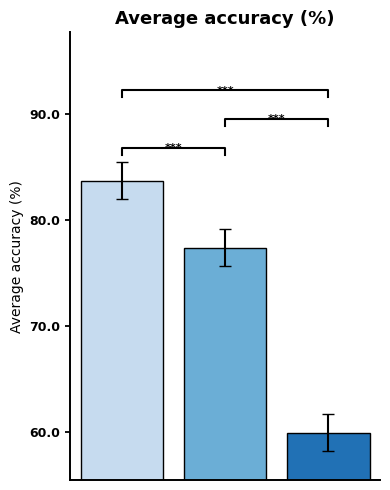


--- Average reaction time (s) ---
Means for average_reaction_time:
  H: 2.802
  L: 2.234
  M: 2.941

=== Average reaction time (s) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 8633.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4166 -0.7770 -0.3346  0.6437  4.3079 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.1162   0.3408  
 Residual                   4.9572   2.2265  
Number of obs: 1935, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            3.056e+00  2.526e-01  5.122e+01  12.101  < 2e-16 ***
condition.L            4.018e-01  8.767e-02  1.889e+03   4.583 4.89e-06 ***
condition.Q           -3.456e-01  8.767e-02  1.889e+03  -3.942 8.37e-05

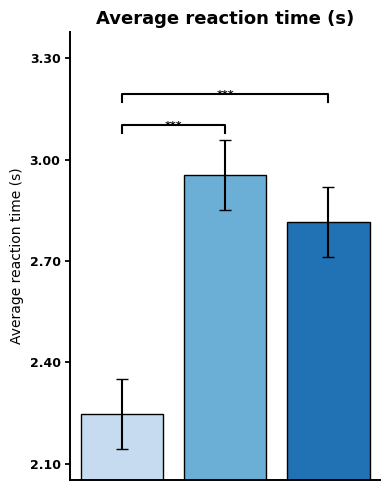

In [12]:
# Use the all_metrics_df from previous cell
if 'all_metrics_df' in locals():
    for metric, label in metrics:
        print(f"\n--- {label} ---")
        # Run mixed effects model and get stats
        pairwise_p, means, cis = run_rpy2_lmer(
            all_metrics_df, metric, label
        )
        # Prepare data for plotting
        conds = ["L", "M", "H"]
        mean_vals = [means.get(c, float('nan')) for c in conds]
        sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]  # 95% CI to SEM
        pvals = [pairwise_p.get(("L", "M"), 1.0), pairwise_p.get(("L", "H"), 1.0), pairwise_p.get(("M", "H"), 1.0)]
        # Plot
        fig, ax = plt.subplots(figsize=(4, 5))
        barplot_ax(ax, mean_vals, sems, pvals, ylabel=label, metric_name=metric)
        ax.set_title(label, fontsize=13, weight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("all_metrics_df not found. Please run the previous cell to generate metrics.")